In [85]:
# Required imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
from dotenv import load_dotenv
from scipy import stats
import warnings
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    roc_curve, 
    precision_recall_curve,
    precision_score, recall_score,
    auc,
    f1_score
)
from datetime import datetime
import re

random_state = 55

warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

load_dotenv()
AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")

## Get Dataset

In [2]:
FILE_NAME = 'feature_frame.csv'
S3_DIR = 'groceries/box_builder_dataset/'
BUCKET_NAME = 'zrive-ds-data'
S3_PATH = "s3://" + BUCKET_NAME + S3_DIR + FILE_NAME
LOCAL_DATA_PATH = 'data/'
LOCAL_FILE_PATH = LOCAL_DATA_PATH + FILE_NAME

def get_data_from_s3():
    """Download data from S3 if not exists locally."""
    os.makedirs(LOCAL_DATA_PATH, exist_ok=True)
    
    if os.path.exists(LOCAL_FILE_PATH):
        print(f"File already exists at {LOCAL_FILE_PATH}")
        return
    
    try:
        s3 = boto3.client('s3',
                         aws_access_key_id=AWS_ACCESS_KEY_ID,
                         aws_secret_access_key=AWS_SECRET_ACCESS_KEY)
        
        key = S3_DIR + FILE_NAME
        
        print(f"Downloading from {S3_PATH}")
        s3.download_file(BUCKET_NAME, key, LOCAL_FILE_PATH)
        print(f"File downloaded successfully to {LOCAL_FILE_PATH}")
        
    except Exception as e:
        print(f"Error downloading file: {e}")
        raise

# Download data if needed
get_data_from_s3()

# Load the dataset
df = pd.read_csv(LOCAL_FILE_PATH)


File already exists at data/feature_frame.csv


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

In [47]:
df.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [48]:
df['outcome'].value_counts(normalize=True)

outcome
0.0    0.988463
1.0    0.011537
Name: proportion, dtype: float64

It's a very unbalanced dataset.

- Label 1 -> 1.15%
- Label 0 -> 98.85%

## Filtering Data

We should only be focusing on purchases of at least 5 items, since it is a requirement coming from the sales team.

In [46]:
items_bought_per_order = df[df['outcome']==1].groupby('order_id').size().reset_index(name='items_bought')
# row num diference between df and items_bought_per_order
df_with_count = df.merge(items_bought_per_order, on='order_id', how='left')
df_with_count['items_bought'].fillna(0, inplace=True)

sales_df = df_with_count[df_with_count['items_bought'] > 4]
print(f"Deleted items with less than 5 items bought: {len(df_with_count) - len(sales_df)}  ({(len(df_with_count) - len(sales_df))*100/len(df_with_count):.2f}%)")

Deleted items with less than 5 items bought: 716596  (24.88%)


## Building linear model

We have the dataset ready for sales team, now, we have to develop a machine learning model that, given a user and a product, predicts if the user would purchase. 

In [68]:
sales_df.columns

Index(['variant_id', 'product_type', 'order_id', 'user_id', 'created_at',
       'order_date', 'user_order_seq', 'outcome', 'ordered_before',
       'abandoned_before', 'active_snoozed', 'set_as_regular',
       'normalised_price', 'discount_pct', 'vendor', 'global_popularity',
       'count_adults', 'count_children', 'count_babies', 'count_pets',
       'people_ex_baby', 'days_since_purchase_variant_id',
       'avg_days_to_buy_variant_id', 'std_days_to_buy_variant_id',
       'days_since_purchase_product_type', 'avg_days_to_buy_product_type',
       'std_days_to_buy_product_type', 'items_bought'],
      dtype='object')

So, we have to build a model to predict the 'outcome' feature given the other features:

- User info ->    ```user_order_seq```, ```count_adults```, ```count_children```, ```count_babies```, ```count_pets```, ```people_ex_baby```
- Product info -> ```product_type```, ```normalised_price```, ```discount_pct```, ```vendor```, ```global_popularity```
- Product-User info -> ```ordered_before```, ```abandoned_before```, ```active_snoozed```, ```set_as_regular``` and those related with days since...
- Target -> ```outcome```

What happens with other variables? 

- IDs -> Don`t give numeric information, delete it (```order_id``` will be important to split data, but then, delete it)
- Items_bought -> We won´t have that info in production


We still have 2 variables left: 
1. ```created_at```: In production will be the current date. I will preprocess it and get day num, month num and week num.
2. ```order_date```: Redundant, delete it. 


In [76]:
target = 'outcome'
cols_to_drop = ['variant_id', 'user_id', 'order_date', 'items_bought']
order_id_col = 'order_id'

feature_cols = sales_df.columns[~sales_df.columns.isin(cols_to_drop + [target])]

X = sales_df[feature_cols]
y = sales_df[target]
X.shape, y.shape

((2163953, 23), (2163953,))

### Data Split

I'll split the data in three subsets:
1. Train Data -> ~70%
2. Validation data -> ~20%
3. Test data -> ~10%

The key in most supervised learning is how we split the data. In this case, I will not divide products in same order in different data splits, in order to avoid data leakage

In [86]:
def split_data(
        df: pd.DataFrame, 
        train_size: int = 0.7, val_size: int = 0.2, random_state:int=55
    ) -> tuple:


    gss1 = GroupShuffleSplit(n_splits=1, train_size=train_size, random_state=random_state)
    train_idx, temp_idx = next(gss1.split(X, y, groups=df[order_id_col]))

    X_train = X.iloc[train_idx].copy()
    y_train = y.iloc[train_idx].copy()

    X_temp = X.iloc[temp_idx].copy()
    y_temp = y.iloc[temp_idx].copy()
    groups_temp = df.iloc[temp_idx][order_id_col].copy()

    remaining_proportion = 1 - train_size
    val_proportion_of_remaining = val_size / remaining_proportion

    gss2 = GroupShuffleSplit(n_splits=1, train_size=val_proportion_of_remaining, random_state=random_state)
    val_idx, test_idx = next(gss2.split(X_temp, y_temp, groups=groups_temp))

    X_val = X_temp.iloc[val_idx].copy()
    y_val = y_temp.iloc[val_idx].copy()
    
    X_test = X_temp.iloc[test_idx].copy()
    y_test = y_temp.iloc[test_idx].copy()

    train_orders = set(X_train[order_id_col].unique())
    val_orders = set(X_val[order_id_col].unique())
    test_orders = set(X_test[order_id_col].unique())

    X_train.drop(columns=[order_id_col], inplace=True)
    X_val.drop(columns=[order_id_col], inplace=True)
    X_test.drop(columns=[order_id_col], inplace=True)

    assert len(train_orders.intersection(val_orders)) == 0, "There are duplicate orders between train and val"
    assert len(train_orders.intersection(test_orders)) == 0, "There are duplicate orders between train and test"
    assert len(val_orders.intersection(test_orders)) == 0, "There are duplicate orders between val and test"

    print(f"Split completed:")
    print(f"  Train ({((len(X_train))*100/(len(sales_df))):.2f}%): {len(X_train)} rows, {len(train_orders)} unique orders")
    print(f"  Val ({((len(X_val))*100/(len(sales_df))):.2f}%):   {len(X_val)} rows, {len(val_orders)} unique orderss")
    print(f"  Test ({((len(X_test))*100/(len(sales_df))):.2f}%):  {len(X_test)} rows, {len(test_orders)} unique orders")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = split_data(sales_df, random_state=random_state)

Split completed:
  Train (69.85%): 1511564 rows, 1822 unique orders
  Val (20.10%):   434859 rows, 520 unique orderss
  Test (10.05%):  217530 rows, 261 unique orders


### Data preprocessing

I'll make 2 types of preprocessing:
1. Date preprocesing -> ```created_at```
2. Categorical encoding -> ```vendor``` and ```product_type``` 

In [61]:
class DateFeatureTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, date_column='order_date', drop_original=True):
        self.date_column = date_column
        self.drop_original = drop_original
        
    def process_date(self, input_str):
        date_str = input_str.split(' ')[0]
        
        # Validate date string input
        regex = re.compile(r'\d{4}-\d{2}-\d{2}')
        if not re.match(regex, date_str):
            return {}  # Manejar error silenciosamente o registrar
        
        # Process date features
        my_date = datetime.strptime(date_str, '%Y-%m-%d').date()
        date_feats = {}
        
        date_feats['year'] = int(my_date.strftime('%Y'))
        date_feats['month_num'] = int(my_date.strftime('%m'))
        date_feats['dom'] = int(my_date.strftime('%d'))
        date_feats['doy'] = int(my_date.strftime('%j'))
        date_feats['woy'] = int(my_date.strftime('%W'))
        
        # Fixing day of week to start on Mon (1), end on Sun (7)
        dow = my_date.strftime('%w')
        if dow == '0': dow = 7
        date_feats['dow_num'] = int(dow)
        
        date_feats['is_weekend'] = 1 if int(dow) > 5 else 0
        
        return date_feats
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        
        date_features = []
        for date_value in X_copy[self.date_column]:
            date_features.append(self.process_date(date_value))
        
        date_df = pd.DataFrame(date_features, index=X_copy.index)
        
        X_transformed = pd.concat([X_copy, date_df], axis=1)
        
        if self.drop_original and self.date_column in X_transformed.columns:
            X_transformed = X_transformed.drop(columns=[self.date_column])
            
        return X_transformed


# 2. Transformador para encodificación de frecuencia
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, categorical_columns):
        self.categorical_columns = categorical_columns
        self.frequency_maps = {}
        
    def fit(self, X, y=None):
        for column in self.categorical_columns:
            if column in X.columns:
                frequencies = X[column].value_counts(normalize=True).to_dict()
                self.frequency_maps[column] = frequencies
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        
        for column in self.categorical_columns:
            if column in X_copy.columns:
                # Para valores no vistos en entrenamiento, asigna la frecuencia más baja
                default_value = min(self.frequency_maps[column].values()) if self.frequency_maps[column] else 0
                
                # Transforma aplicando el mapeo, con un valor predeterminado para categorías nuevas
                X_copy[column] = X_copy[column].map(lambda x: self.frequency_maps[column].get(x, default_value))
                
        return X_copy


def create_preprocessing_pipeline() -> Pipeline:
    categorical_columns = ['product_type', 'vendor']
    date_column = 'order_date'
    
    preprocessing_pipeline = Pipeline([
        
        ('date_transformer', DateFeatureTransformer(
            date_column=date_column, 
            drop_original=True
        )),
        
        ('frequency_encoder', FrequencyEncoder(
            categorical_columns=categorical_columns
        )),
        
        ('scaler', StandardScaler())
    ])
    
    return preprocessing_pipeline

### Model Fitting

In [62]:
print(f"Features: {X_train.columns.tolist()}")

Features: ['product_type', 'order_date', 'user_order_seq', 'ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular', 'normalised_price', 'discount_pct', 'vendor', 'global_popularity', 'count_adults', 'count_children', 'count_babies', 'count_pets', 'people_ex_baby', 'days_since_purchase_variant_id', 'avg_days_to_buy_variant_id', 'std_days_to_buy_variant_id', 'days_since_purchase_product_type', 'avg_days_to_buy_product_type', 'std_days_to_buy_product_type', 'items_comprados']


In [ ]:
full_pipeline = Pipeline([
    ('preprocessor', create_preprocessing_pipeline()),
    ('classifier', LogisticRegression(
            penalty=None, 
            class_weight=None, 
            max_iter=1000, 
            random_state=random_state
        ))
])

full_pipeline.fit(X_train, y_train)

Evaluate a classification model. Get the metrics

In [79]:
def evaluate_classification_model(
        y_true, y_pred, figsize=(20, 15), 
        title_prefix="", save_fig=False, filename=None
    ) -> dict:
    
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    metrics = {
        'Accuracy': (tp + tn) / (tp + tn + fp + fn),
        'Precision': tp / (tp + fp) if (tp + fp) > 0 else 0,
        'Recall': tp / (tp + fn) if (tp + fn) > 0 else 0,
        'Specificity': tn / (tn + fp) if (tn + fp) > 0 else 0,
        'F1 Score': f1_score(y_true, y_pred),
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn
    }
    
    fig = plt.figure(figsize=figsize)
    
    plt.subplot(2, 3, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{title_prefix}Confusion Matrix', fontsize=14)
    plt.ylabel('Real Label')
    plt.xlabel('Predicted Label')
    plt.xticks([0.5, 1.5], ['0', '1'])
    plt.yticks([0.5, 1.5], ['0', '1'])
    
    plt.subplot(2, 3, 2)
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1 Score']
    
    values = [metrics[m] for m in metrics_to_plot]
    bars = plt.barh(metrics_to_plot, values, color='steelblue')
    plt.xlim(0, 1)
    plt.title(f'{title_prefix}Metrics', fontsize=14)

    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                 f'{width:.4f}', va='center')
    
    
    
    plt.subplot(2, 3, 5)
    plt.axis('off')
    metrics_cell_text = [[key, f"{value:.4f}" if isinstance(value, float) else value] 
                         for key, value in metrics.items()]
    plt.table(cellText=metrics_cell_text, colLabels=['Metric', 'Value'], 
              loc='center', cellLoc='center')
    plt.title(f'{title_prefix}Metrics Table', fontsize=14)
    
    plt.tight_layout()
    
    if save_fig:
        if filename is None:
            filename = f"{title_prefix.strip()}_model_evaluation.png" if title_prefix else "model_evaluation.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    print(f"\n{title_prefix}Clasification report:")
    print(classification_report(y_true, y_pred))
    
    return metrics

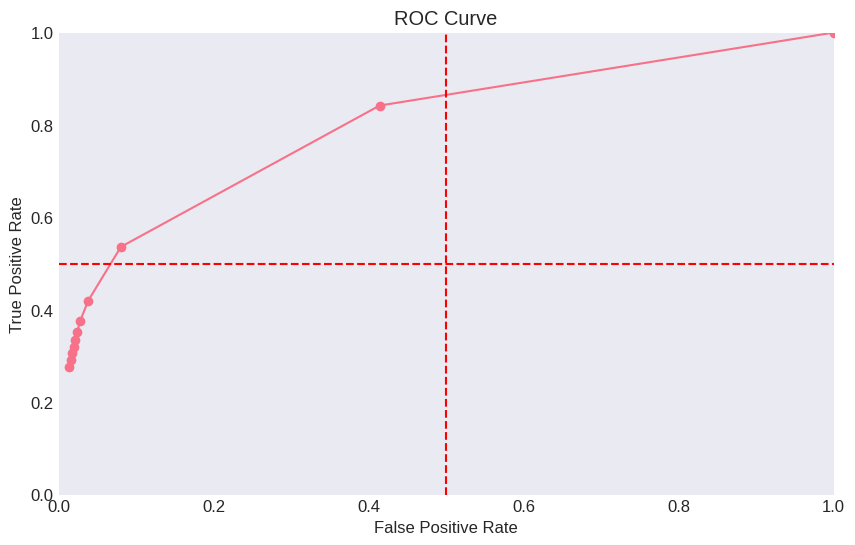

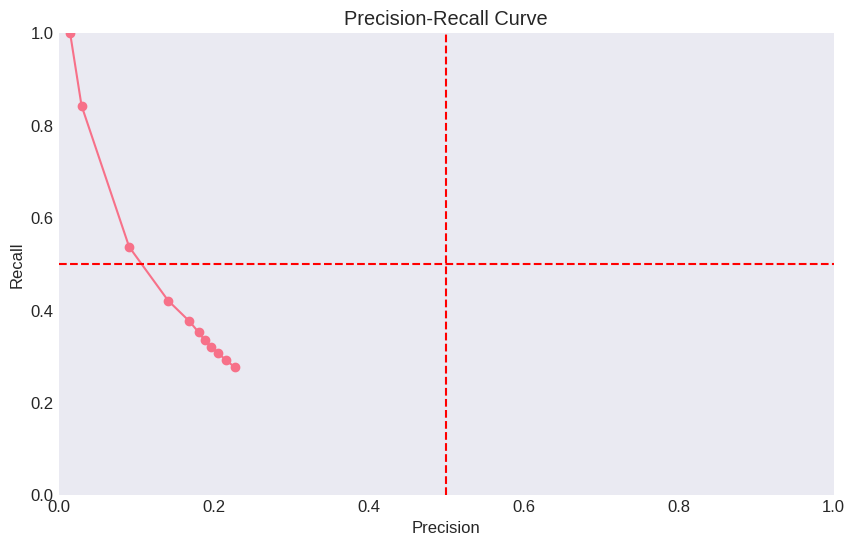

In [99]:
y_val_proba = full_pipeline.predict_proba(X_val)[:, 1]

thresholds = np.arange(0.0, 0.11, 0.01)
true_positive_rates = []
false_positive_rates = []
precisions = []
for threshold in thresholds:
    y_pred = (y_val_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    true_positive_rate = tp / (tp + fn) if (tp + fn) > 0 else 0
    false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0

    true_positive_rates.append(true_positive_rate)
    false_positive_rates.append(false_positive_rate)
    precisions.append(precision)

# Plotting ROC curve
plt.figure(figsize=(10, 6))
plt.plot(false_positive_rates, true_positive_rates, marker='o')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.axhline(y=0.5, color='r', linestyle='--')
plt.axvline(x=0.5, color='r', linestyle='--')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

# Plotting Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(precisions, true_positive_rates, marker='o')
plt.title('Precision-Recall Curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.grid()
plt.axhline(y=0.5, color='r', linestyle='--')
plt.axvline(x=0.5, color='r', linestyle='--')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()
    

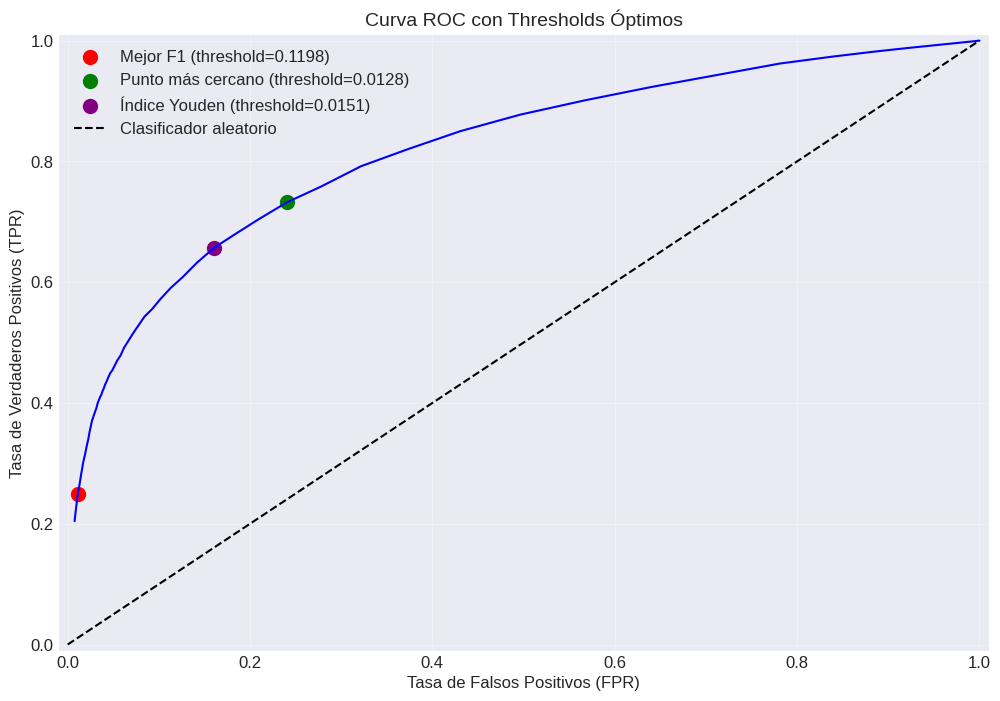

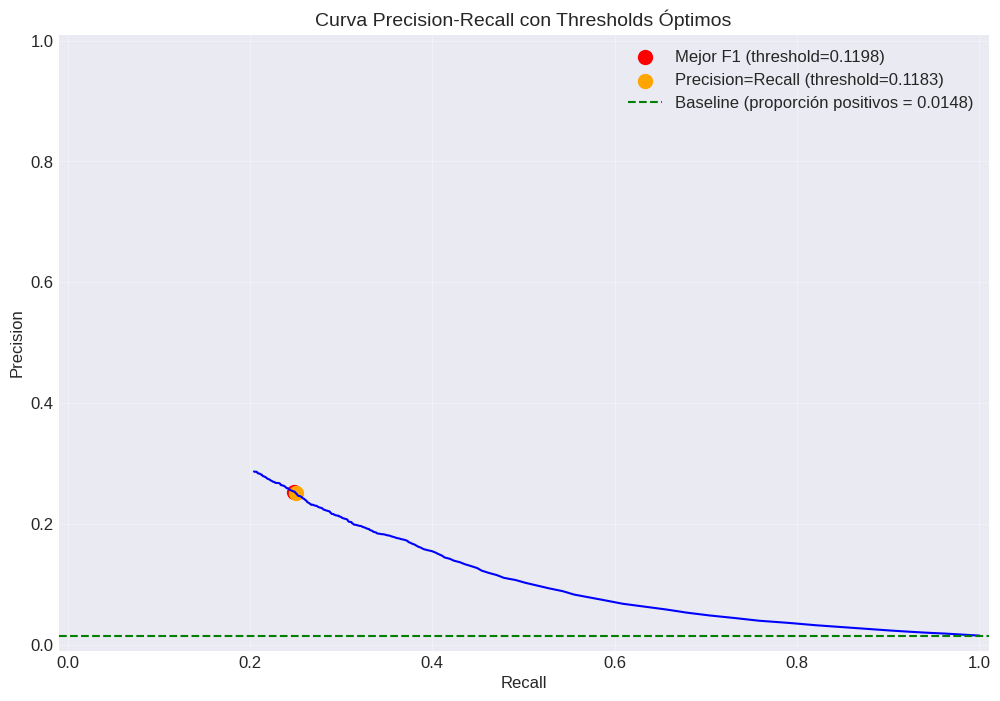

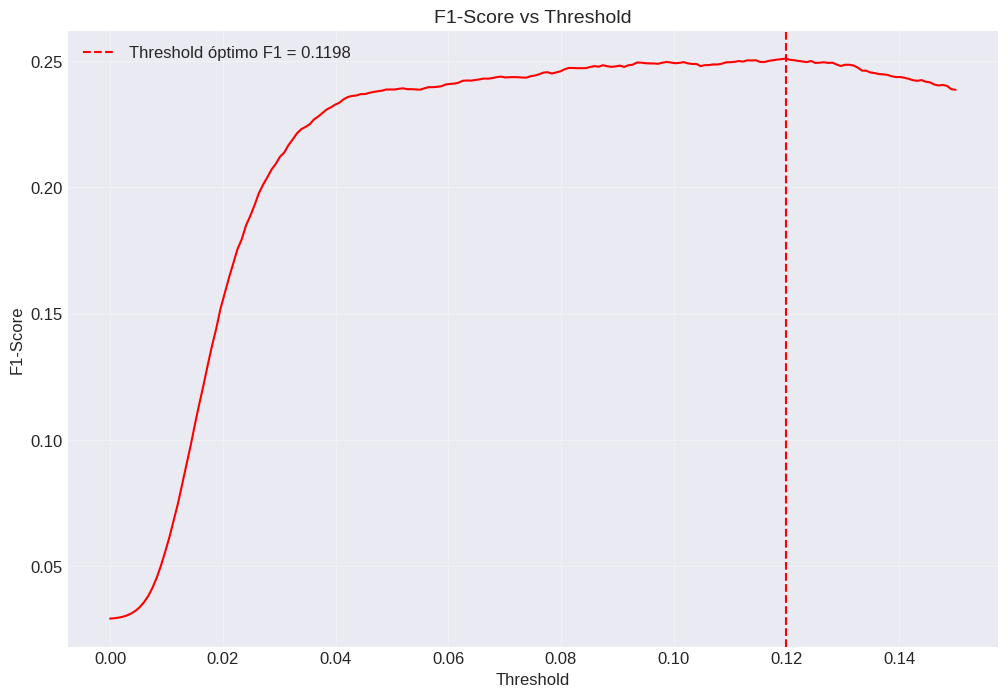


=== Comparación de Métricas con Diferentes Thresholds ===
Criterio             Threshold  Precision  Recall     F1-Score  
------------------------------------------------------------
Mejor F1             0.1198      0.2532      0.2487      0.2509
Punto más cercano    0.0128      0.0438      0.7324      0.0826
Índice Youden        0.0151      0.0578      0.6574      0.1063
Precision=Recall     0.1183      0.2509      0.2502      0.2505


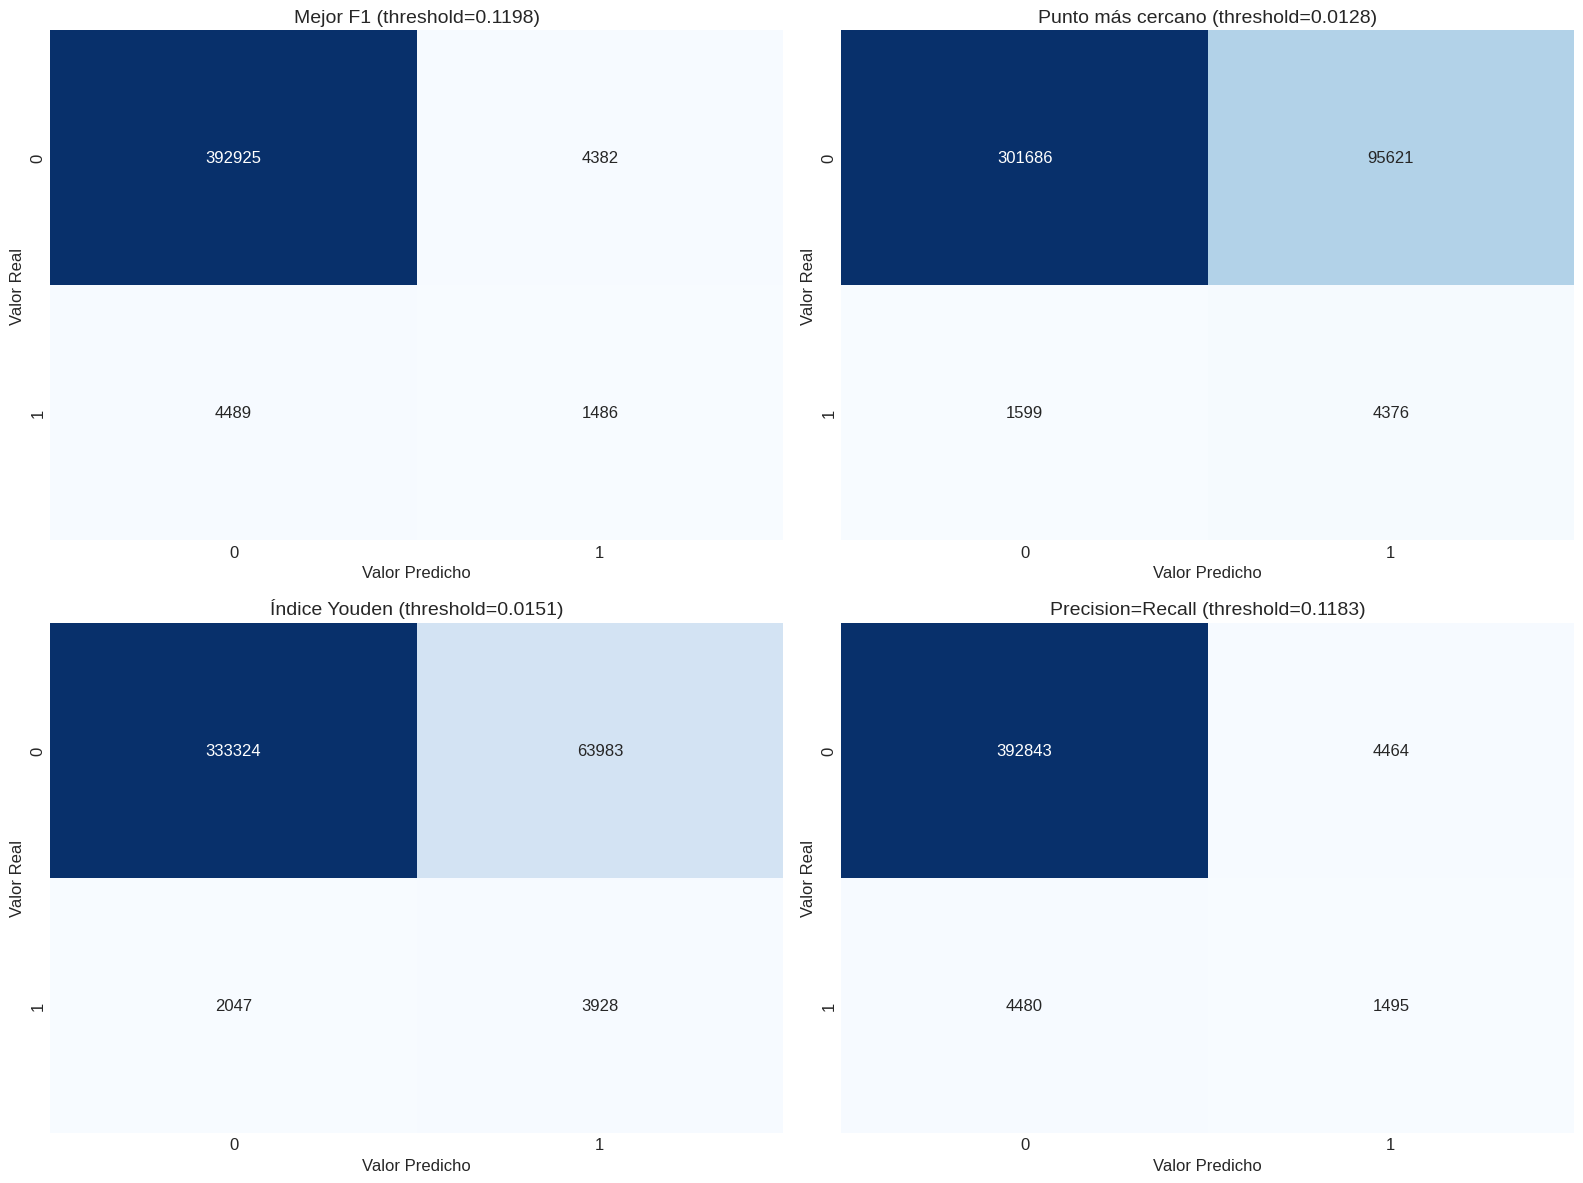

In [106]:
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt

# Obtenemos probabilidades
y_val_proba = full_pipeline.predict_proba(X_val)[:, 1]

# Usamos thresholds más granulares 
thresholds = np.linspace(0.0, 0.15, 200)  # Más valores entre 0 y 0.15

# Calculamos métricas para cada threshold
true_positive_rates = []
false_positive_rates = []
precisions = []
f1_scores = []
distances_to_perfect = []  # Distancia a (0,1) en la curva ROC
youden_indices = []        # Índice de Youden (TPR - FPR)

for threshold in thresholds:
    y_pred = (y_val_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1 = f1_score(y_val, y_pred)
    
    true_positive_rates.append(tpr)
    false_positive_rates.append(fpr)
    precisions.append(precision)
    f1_scores.append(f1)
    
    # Distancia euclídea a punto perfecto (0,1) en curva ROC
    distance = np.sqrt((1-tpr)**2 + fpr**2)
    distances_to_perfect.append(distance)
    
    # Índice de Youden (maximizar TPR-FPR)
    youden_indices.append(tpr - fpr)

# Encontrar thresholds óptimos según diferentes criterios
best_f1_idx = np.argmax(f1_scores)
best_f1_threshold = thresholds[best_f1_idx]

best_distance_idx = np.argmin(distances_to_perfect)
best_distance_threshold = thresholds[best_distance_idx]

best_youden_idx = np.argmax(youden_indices)
best_youden_threshold = thresholds[best_youden_idx]

# Encontrar punto donde Precision ≈ Recall
precision_recall_diff = np.abs(np.array(precisions) - np.array(true_positive_rates))
balanced_idx = np.argmin(precision_recall_diff)
balanced_threshold = thresholds[balanced_idx]

# Plotting ROC curve con mejores puntos marcados
plt.figure(figsize=(12, 8))
plt.plot(false_positive_rates, true_positive_rates, 'b-')

# Marcar puntos óptimos
plt.scatter(false_positive_rates[best_f1_idx], true_positive_rates[best_f1_idx], 
           color='red', s=100, label=f'Mejor F1 (threshold={best_f1_threshold:.4f})')

plt.scatter(false_positive_rates[best_distance_idx], true_positive_rates[best_distance_idx], 
           color='green', s=100, label=f'Punto más cercano (threshold={best_distance_threshold:.4f})')

plt.scatter(false_positive_rates[best_youden_idx], true_positive_rates[best_youden_idx], 
           color='purple', s=100, label=f'Índice Youden (threshold={best_youden_threshold:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Clasificador aleatorio')
plt.title('Curva ROC con Thresholds Óptimos', fontsize=14)
plt.xlabel('Tasa de Falsos Positivos (FPR)', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.show()

# Plotting Precision-Recall curve con mejores puntos
plt.figure(figsize=(12, 8))
plt.plot(true_positive_rates, precisions, 'b-')

# Marcar puntos óptimos
plt.scatter(true_positive_rates[best_f1_idx], precisions[best_f1_idx], 
           color='red', s=100, label=f'Mejor F1 (threshold={best_f1_threshold:.4f})')

plt.scatter(true_positive_rates[balanced_idx], precisions[balanced_idx], 
           color='orange', s=100, label=f'Precision=Recall (threshold={balanced_threshold:.4f})')

# Línea base (proporción de positivos)
plt.axhline(y=sum(y_val)/len(y_val), color='green', linestyle='--', 
            label=f'Baseline (proporción positivos = {sum(y_val)/len(y_val):.4f})')

plt.title('Curva Precision-Recall con Thresholds Óptimos', fontsize=14)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.show()

# También graficamos F1-Score vs Threshold
plt.figure(figsize=(12, 8))
plt.plot(thresholds, f1_scores, 'r-')
plt.axvline(x=best_f1_threshold, color='red', linestyle='--', 
           label=f'Threshold óptimo F1 = {best_f1_threshold:.4f}')
plt.title('F1-Score vs Threshold', fontsize=14)
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('F1-Score', fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# Comparación de métricas con diferentes thresholds
print("\n=== Comparación de Métricas con Diferentes Thresholds ===")
print(f"{'Criterio':<20} {'Threshold':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
print("-" * 60)

for idx, (name, threshold_idx) in enumerate([
    ('Mejor F1', best_f1_idx),
    ('Punto más cercano', best_distance_idx),
    ('Índice Youden', best_youden_idx),
    ('Precision=Recall', balanced_idx)
]):
    threshold = thresholds[threshold_idx]
    precision = precisions[threshold_idx]
    recall = true_positive_rates[threshold_idx]
    f1 = f1_scores[threshold_idx]
    
    print(f"{name:<20} {threshold:.4f}{' ':<5} {precision:.4f}{' ':<5} {recall:.4f}{' ':<5} {f1:.4f}")

# Mostrar matrices de confusión para los thresholds seleccionados
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (name, threshold_idx) in enumerate([
    ('Mejor F1', best_f1_idx),
    ('Punto más cercano', best_distance_idx),
    ('Índice Youden', best_youden_idx),
    ('Precision=Recall', balanced_idx)
]):
    threshold = thresholds[threshold_idx]
    y_pred = (y_val_proba >= threshold).astype(int)
    cm = confusion_matrix(y_val, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], cbar=False)
    axes[idx].set_title(f'{name} (threshold={threshold:.4f})', fontsize=14)
    axes[idx].set_ylabel('Valor Real', fontsize=12)
    axes[idx].set_xlabel('Valor Predicho', fontsize=12)
    axes[idx].set_xticks([0.5, 1.5])
    axes[idx].set_xticklabels(['0', '1'])
    axes[idx].set_yticks([0.5, 1.5])
    axes[idx].set_yticklabels(['0', '1'])

plt.tight_layout()
plt.show()

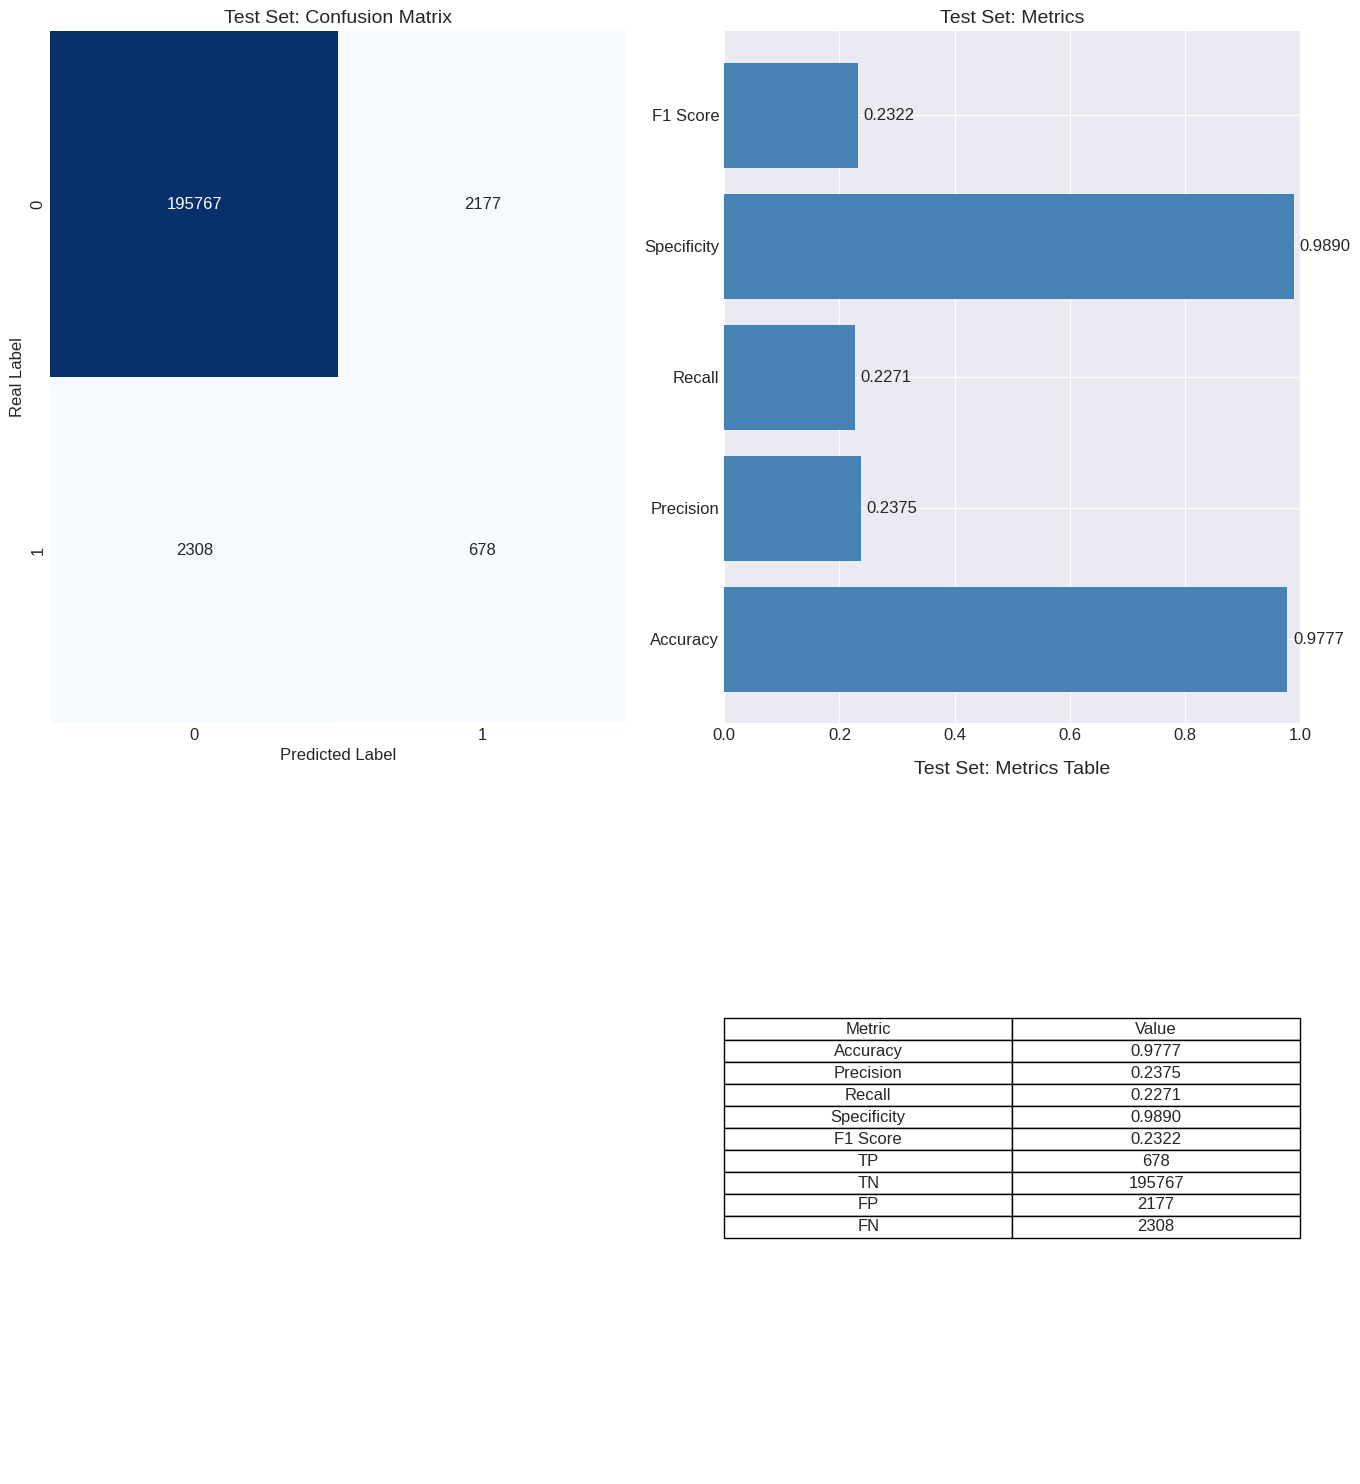


Test Set: Clasification report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    197944
         1.0       0.24      0.23      0.23      2986

    accuracy                           0.98    200930
   macro avg       0.61      0.61      0.61    200930
weighted avg       0.98      0.98      0.98    200930



In [110]:
threshold = best_f1_threshold
y_test_proba = full_pipeline.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= threshold).astype(int)
test_metrics = evaluate_classification_model(
    y_test, y_test_pred, 
    title_prefix="Test Set: ", 
    figsize=(20, 15),
)

In [121]:
pipeline1 = Pipeline([
    ('preprocessor', create_preprocessing_pipeline()),
    ('classifier', LogisticRegression(
            penalty=None, 
            class_weight=None, 
            max_iter=1000, 
            random_state=random_state
        ))
])

pipeline2 = Pipeline([
    ('preprocessor', create_preprocessing_pipeline()),
    ('classifier', LogisticRegression(
            penalty='l2', 
            class_weight=None,
            max_iter=1000, 
            random_state=random_state
        ))
])

pipeline3 = Pipeline([
    ('preprocessor', create_preprocessing_pipeline()),
    ('classifier', LogisticRegression(
            penalty='l2', 
            class_weight={0: 5, 1: 1},  # Penalizamos 5 veces más los FP que los FN
            max_iter=1000, 
            random_state=random_state
        ))
])

pipeline4 = Pipeline([
    ('preprocessor', create_preprocessing_pipeline()),
    ('classifier', LogisticRegression(
            penalty='l2', 
            class_weight='balanced',
            max_iter=1000, 
            random_state=random_state,
        ))
])


pipelines = [pipeline1, pipeline2, pipeline3, pipeline4]
thresholds = np.linspace(0.0, 0.2, 100)

def fit_pipeline(pipeline, X_train, y_train):
    """Fit the pipeline to the training data."""
    print(f"Fitting pipeline: {pipeline.named_steps['classifier'].__class__.__name__}")
    pipeline.fit(X_train, y_train)
    return pipeline

def get_best_treshold(pipeline, X_val, y_val, thresholds):
    """Get the best threshold for the given pipeline (best F1 score)."""
    y_val_proba = pipeline.predict_proba(X_val)[:, 1]
    true_positive_rates = []
    false_positive_rates = []
    precisions = []
    f1_scores = []

    for threshold in thresholds:
        y_pred = (y_val_proba >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
        
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1 = f1_score(y_val, y_pred)
        
        true_positive_rates.append(tpr)
        false_positive_rates.append(fpr)
        precisions.append(precision)
        f1_scores.append(f1)

    best_f1_idx = np.argmax(f1_scores)
    best_f1_threshold = thresholds[best_f1_idx]
    return best_f1_threshold

for pipeline in pipelines:
    fit_pipeline(pipeline, X_train, y_train)
    threshold = get_best_treshold(pipeline, X_val, y_val, thresholds)
    print(f"Best threshold for {pipeline.named_steps['classifier'].__class__.__name__}: {threshold:.4f}")
    y_preds = (pipeline.predict_proba(X_test)[:, 1] >= threshold).astype(int)
    evaluate_classification_model(
        y_test, y_preds, 
        title_prefix=f"Test Set ({pipeline.named_steps['classifier'].__class__.__name__}): ", 
        figsize=(20, 15),
    )

Fitting pipeline: LogisticRegression


KeyboardInterrupt: 

Now we have to choose a model, i'll be looking that with best precision.


--------------------------------------------------------------------------------
Evaluando: LogisticRegression (penalty=None, class_weight=None)
Entrenando modelo...
Calculando threshold óptimo para F1 score...
Threshold que maximiza F1: 0.1183
En validación: Precision=0.2509, Recall=0.2502, F1=0.2505
Evaluando en conjunto de prueba...
Resultados en Test: Precision=0.2354, Recall=0.2284, F1=0.2319
Falsos Positivos: 2215 de 197944 negativos (1.12%)

--------------------------------------------------------------------------------
Evaluando: LogisticRegression (penalty=l2, class_weight=None)
Entrenando modelo...
Calculando threshold óptimo para F1 score...
Threshold que maximiza F1: 0.1183
En validación: Precision=0.2509, Recall=0.2502, F1=0.2505
Evaluando en conjunto de prueba...
Resultados en Test: Precision=0.2354, Recall=0.2284, F1=0.2319
Falsos Positivos: 2215 de 197944 negativos (1.12%)

--------------------------------------------------------------------------------
Evaluando: Log

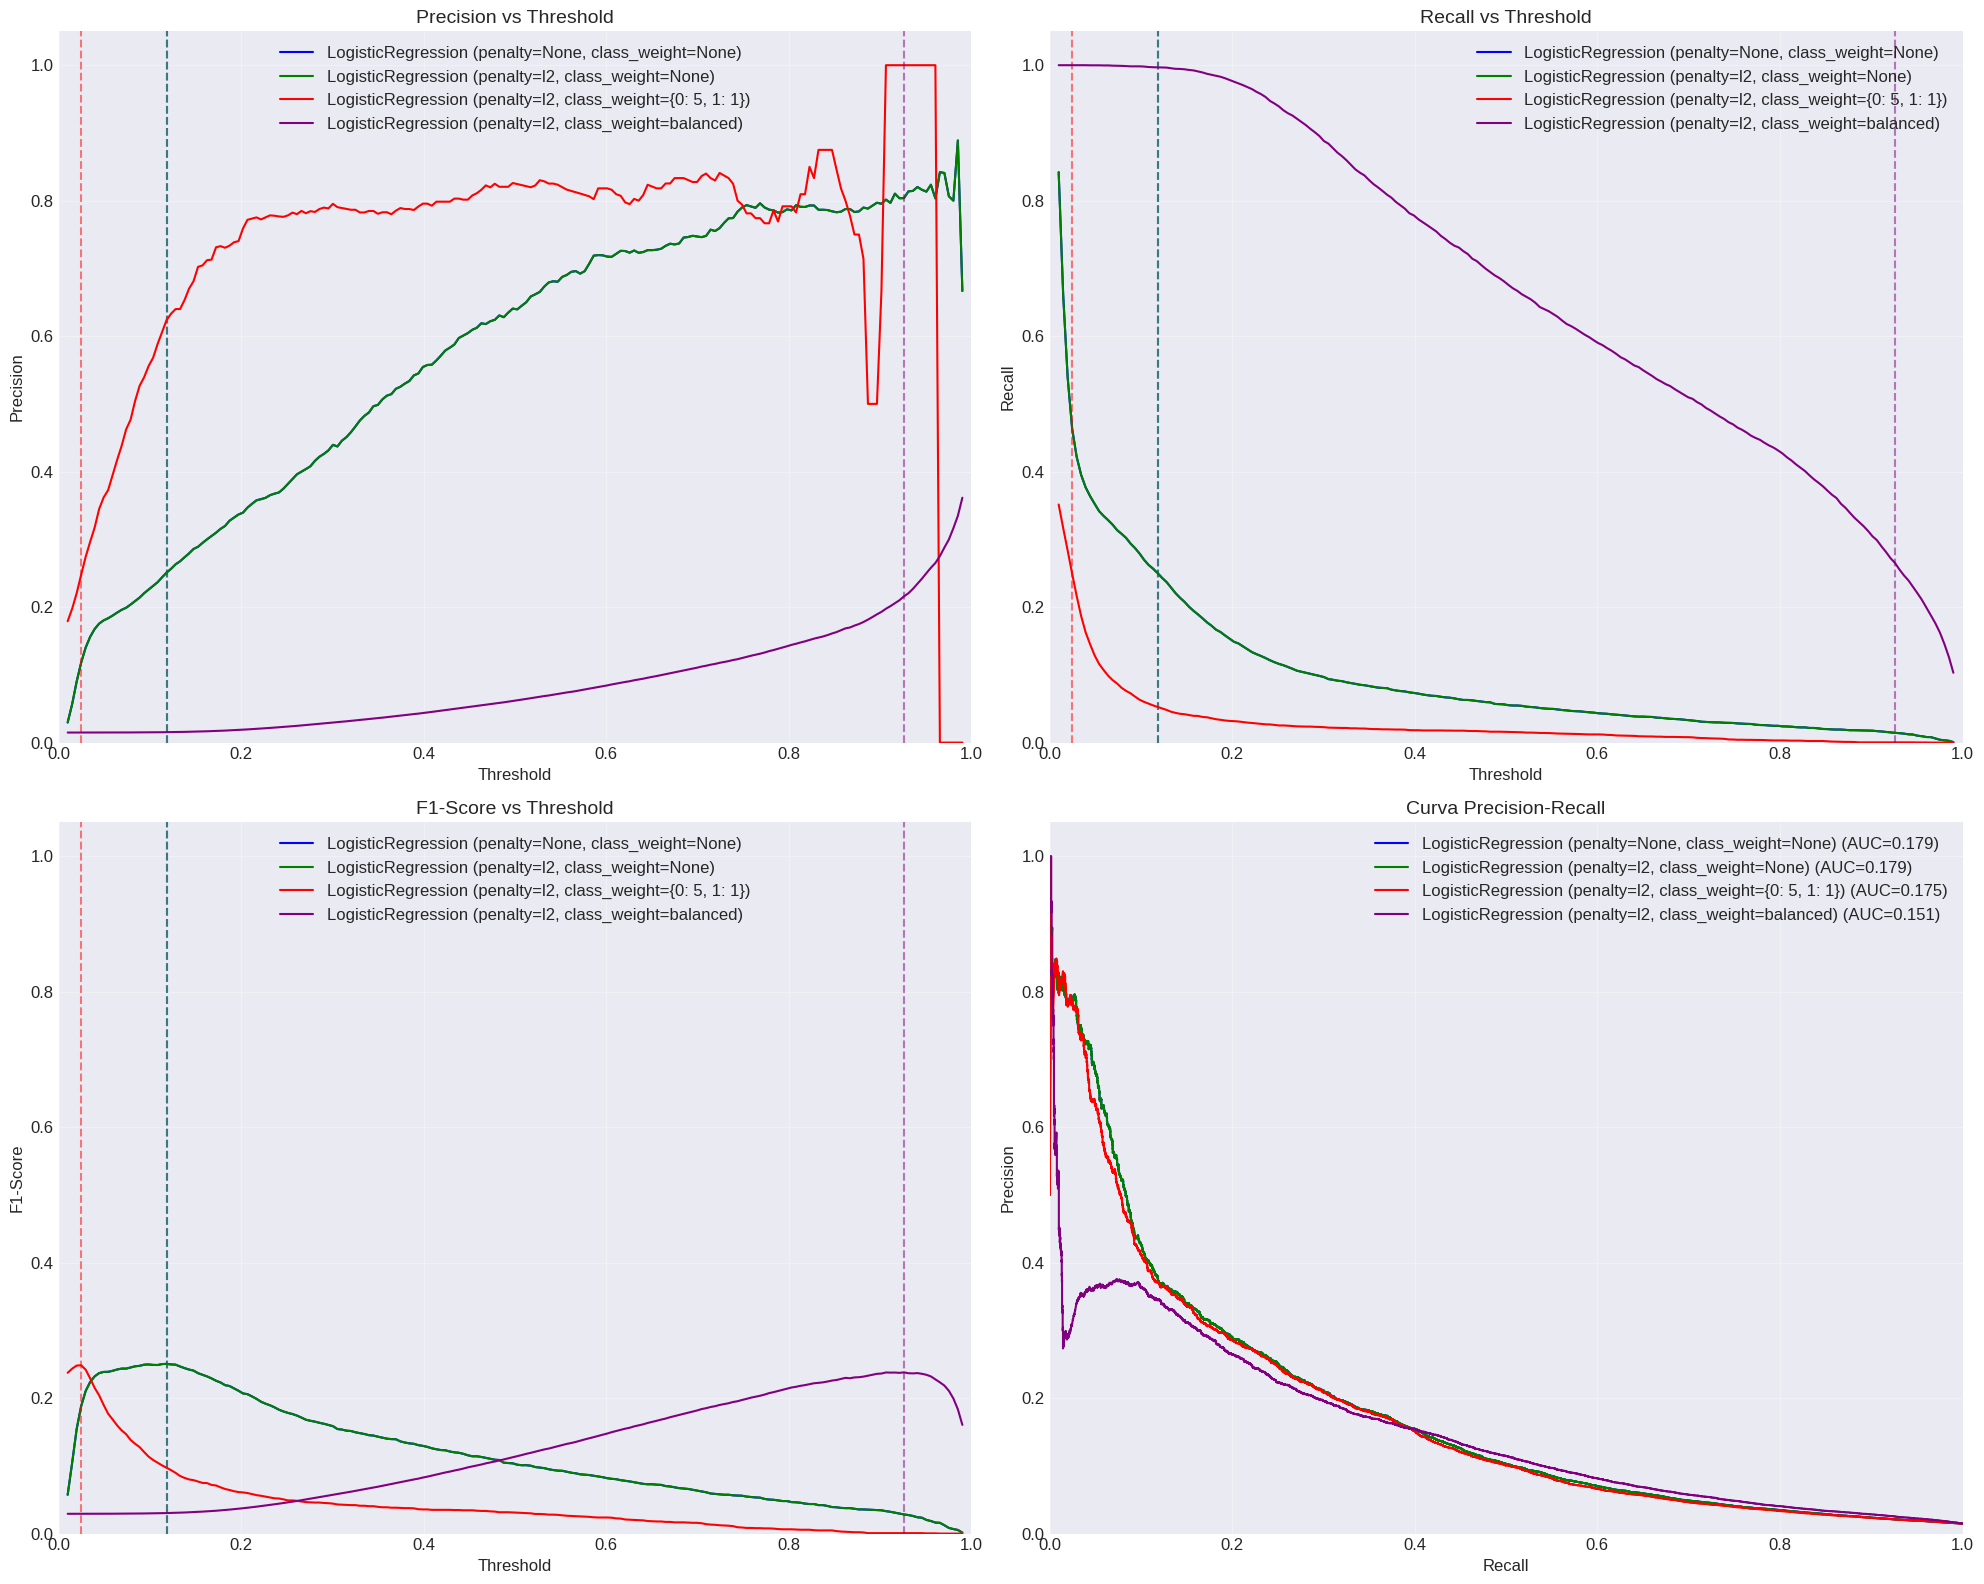


COMPARACIÓN DE MODELOS (ORDENADOS POR PRECISIÓN PARA MINIMIZAR FALSOS POSITIVOS)


,Pipeline,Threshold (Max F1),Test Precision,Test Recall,Test F1,Falsos Positivos,Tasa FP,PR AUC
0,"LogisticRegression (penalty=None, class_weight...",0.118342,0.235416,0.228399,0.231854,2215,0.011190,0.179351
1,"LogisticRegression (penalty=l2, class_weight=N...",0.118342,0.235416,0.228399,0.231854,2215,0.011190,0.179351
2,"LogisticRegression (penalty=l2, class_weight={...",0.024774,0.231695,0.225720,0.228668,2235,0.011291,0.174693
3,"LogisticRegression (penalty=l2, class_weight=b...",0.925980,0.204644,0.253851,0.226607,2946,0.014883,0.151042


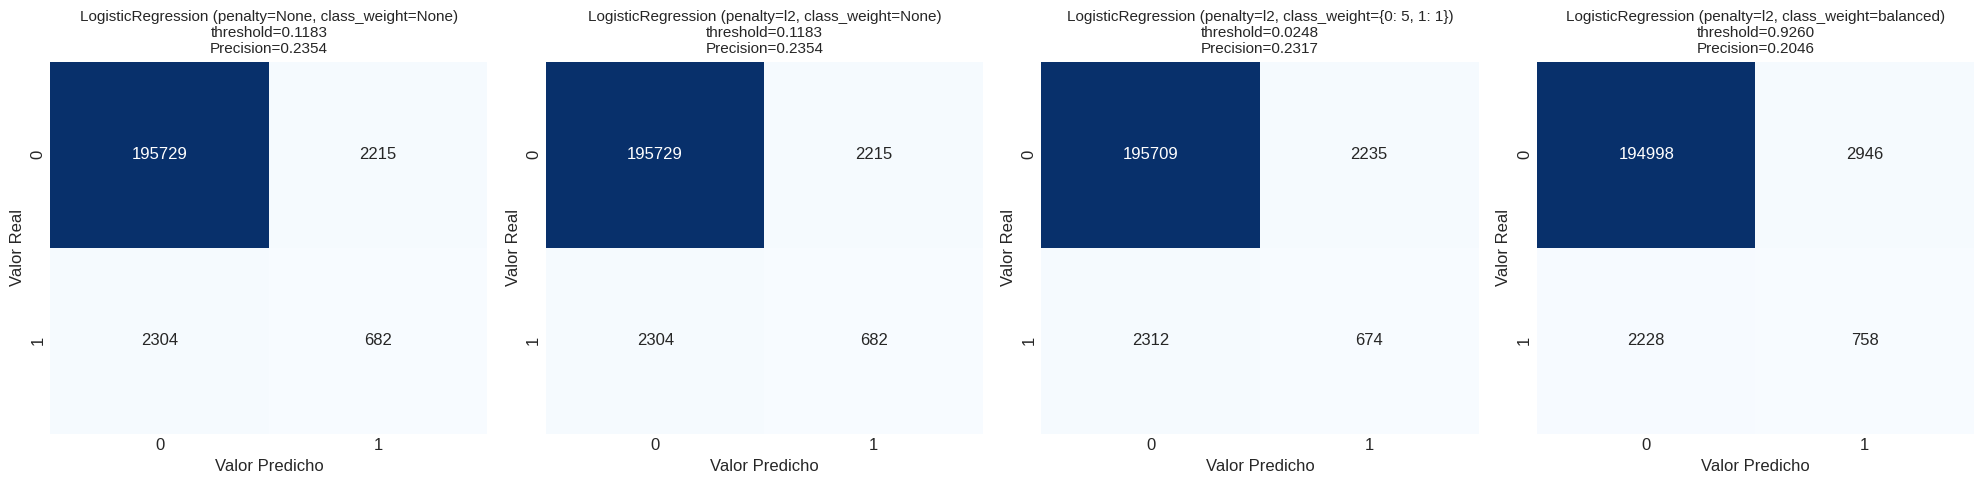


🏆 MEJOR MODELO PARA MINIMIZAR FALSOS POSITIVOS: LogisticRegression (penalty=None, class_weight=None)
   Threshold óptimo (Max F1): 0.1183
   Precisión en Test: 0.2354
   Recall en Test: 0.2284
   F1 en Test: 0.2319
   Falsos Positivos: 2215 (Tasa: 1.12%)


In [122]:
def optimize_and_compare_models(pipelines, X_train, y_train, X_val, y_val, X_test, y_test, random_state=42):
    """
    Para cada pipeline:
    1. Encuentra el threshold que maximiza F1-score
    2. Evalúa precisión, recall y otras métricas con ese threshold
    3. Compara todos los modelos priorizando precisión
    
    Retorna el mejor modelo para minimizar falsos positivos
    """
    results = {}
    all_pipelines = []
    
    # Configurar figura para gráficos
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink']
    
    for i, pipeline in enumerate(pipelines):
        pipeline_name = pipeline.named_steps['classifier'].__class__.__name__
        if hasattr(pipeline.named_steps['classifier'], 'penalty'):
            penalty = pipeline.named_steps['classifier'].penalty
            class_weight = pipeline.named_steps['classifier'].class_weight
            pipeline_name += f" (penalty={penalty}, class_weight={class_weight})"
        
        print(f"\n{'-'*80}\nEvaluando: {pipeline_name}")
        
        # Entrenar pipeline
        print("Entrenando modelo...")
        pipeline.fit(X_train, y_train)
        all_pipelines.append(pipeline)
        
        # Calcular probabilidades en validación
        y_val_proba = pipeline.predict_proba(X_val)[:, 1]
        
        # Encontrar threshold óptimo para F1 score
        print("Calculando threshold óptimo para F1 score...")
        thresholds = np.linspace(0.01, 0.99, 200)
        f1_scores = []
        precision_values = []
        recall_values = []
        
        for threshold in thresholds:
            y_val_pred = (y_val_proba >= threshold).astype(int)
            f1 = f1_score(y_val, y_val_pred)
            precision = precision_score(y_val, y_val_pred, zero_division=0)
            recall = recall_score(y_val, y_val_pred)
            
            f1_scores.append(f1)
            precision_values.append(precision)
            recall_values.append(recall)
        
        # Obtener threshold que maximiza F1
        best_f1_idx = np.argmax(f1_scores)
        best_f1_threshold = thresholds[best_f1_idx]
        best_f1 = f1_scores[best_f1_idx]
        best_precision = precision_values[best_f1_idx]
        best_recall = recall_values[best_f1_idx]
        
        print(f"Threshold que maximiza F1: {best_f1_threshold:.4f}")
        print(f"En validación: Precision={best_precision:.4f}, Recall={best_recall:.4f}, F1={best_f1:.4f}")
        
        # Evaluar con el threshold óptimo en conjunto de prueba
        print("Evaluando en conjunto de prueba...")
        y_test_proba = pipeline.predict_proba(X_test)[:, 1]
        y_test_pred = (y_test_proba >= best_f1_threshold).astype(int)
        
        # Métricas en test
        test_precision = precision_score(y_test, y_test_pred, zero_division=0)
        test_recall = recall_score(y_test, y_test_pred)
        test_f1 = f1_score(y_test, y_test_pred)
        
        # Matriz de confusión
        tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        
        print(f"Resultados en Test: Precision={test_precision:.4f}, Recall={test_recall:.4f}, F1={test_f1:.4f}")
        print(f"Falsos Positivos: {fp} de {fp+tn} negativos ({fpr*100:.2f}%)")
        
        # Calcular curvas PR y ROC
        precision_curve, recall_curve, _ = precision_recall_curve(y_val, y_val_proba)
        fpr_curve, tpr_curve, _ = roc_curve(y_val, y_val_proba)
        pr_auc = auc(recall_curve, precision_curve)
        roc_auc = auc(fpr_curve, tpr_curve)
        
        # Guardar resultados
        results[pipeline_name] = {
            'pipeline': pipeline,
            'threshold': best_f1_threshold,
            'val_precision': best_precision,
            'val_recall': best_recall,
            'val_f1': best_f1,
            'test_precision': test_precision,
            'test_recall': test_recall,
            'test_f1': test_f1,
            'true_positives': tp,
            'false_positives': fp,
            'false_negatives': fn,
            'true_negatives': tn,
            'fpr': fpr,
            'pr_auc': pr_auc,
            'roc_auc': roc_auc
        }
        
        # Dibujar curva Precision vs Threshold
        axes[0, 0].plot(thresholds, precision_values, label=f"{pipeline_name}", 
                       color=colors[i % len(colors)])
        axes[0, 0].axvline(x=best_f1_threshold, color=colors[i % len(colors)], linestyle='--', alpha=0.5)
        
        # Dibujar curva Recall vs Threshold
        axes[0, 1].plot(thresholds, recall_values, label=f"{pipeline_name}", 
                       color=colors[i % len(colors)])
        axes[0, 1].axvline(x=best_f1_threshold, color=colors[i % len(colors)], linestyle='--', alpha=0.5)
        
        # Dibujar curva F1 vs Threshold
        axes[1, 0].plot(thresholds, f1_scores, label=f"{pipeline_name}", 
                       color=colors[i % len(colors)])
        axes[1, 0].axvline(x=best_f1_threshold, color=colors[i % len(colors)], linestyle='--', alpha=0.5)
        
        # Dibujar curva PR
        axes[1, 1].plot(recall_curve, precision_curve, label=f"{pipeline_name} (AUC={pr_auc:.3f})",
                       color=colors[i % len(colors)])
    
    # Finalizar gráficos
    axes[0, 0].set_title('Precision vs Threshold', fontsize=14)
    axes[0, 0].set_xlabel('Threshold', fontsize=12)
    axes[0, 0].set_ylabel('Precision', fontsize=12)
    axes[0, 0].set_xlim(0, 1)
    axes[0, 0].set_ylim(0, 1.05)
    axes[0, 0].grid(alpha=0.3)
    axes[0, 0].legend(loc='best')
    
    axes[0, 1].set_title('Recall vs Threshold', fontsize=14)
    axes[0, 1].set_xlabel('Threshold', fontsize=12)
    axes[0, 1].set_ylabel('Recall', fontsize=12)
    axes[0, 1].set_xlim(0, 1)
    axes[0, 1].set_ylim(0, 1.05)
    axes[0, 1].grid(alpha=0.3)
    axes[0, 1].legend(loc='best')
    
    axes[1, 0].set_title('F1-Score vs Threshold', fontsize=14)
    axes[1, 0].set_xlabel('Threshold', fontsize=12)
    axes[1, 0].set_ylabel('F1-Score', fontsize=12)
    axes[1, 0].set_xlim(0, 1)
    axes[1, 0].set_ylim(0, 1.05)
    axes[1, 0].grid(alpha=0.3)
    axes[1, 0].legend(loc='best')
    
    axes[1, 1].set_title('Curva Precision-Recall', fontsize=14)
    axes[1, 1].set_xlabel('Recall', fontsize=12)
    axes[1, 1].set_ylabel('Precision', fontsize=12)
    axes[1, 1].set_xlim(0, 1)
    axes[1, 1].set_ylim(0, 1.05)
    axes[1, 1].grid(alpha=0.3)
    axes[1, 1].legend(loc='best')
    
    plt.tight_layout()
    plt.show()
    
    # Crear tabla comparativa ordenada por precisión (para minimizar falsos positivos)
    result_df = pd.DataFrame({
        'Pipeline': list(results.keys()),
        'Threshold (Max F1)': [results[p]['threshold'] for p in results],
        'Test Precision': [results[p]['test_precision'] for p in results],
        'Test Recall': [results[p]['test_recall'] for p in results],
        'Test F1': [results[p]['test_f1'] for p in results],
        'Falsos Positivos': [results[p]['false_positives'] for p in results],
        'Tasa FP': [results[p]['fpr'] for p in results],
        'PR AUC': [results[p]['pr_auc'] for p in results]
    })
    
    # Ordenar por precisión (descendente) para minimizar falsos positivos
    result_df = result_df.sort_values(['Test Precision', 'Test F1'], ascending=[False, False]).reset_index(drop=True)
    
    print("\n" + "="*80)
    print("COMPARACIÓN DE MODELOS (ORDENADOS POR PRECISIÓN PARA MINIMIZAR FALSOS POSITIVOS)")
    print("="*80)
    display(result_df)
    
    # Mostrar matrices de confusión
    fig, axes = plt.subplots(1, len(pipelines), figsize=(5*len(pipelines), 5))
    if len(pipelines) == 1:
        axes = [axes]
    
    for i, pipeline_name in enumerate(results.keys()):
        res = results[pipeline_name]
        cm = np.array([[res['true_negatives'], res['false_positives']], 
                       [res['false_negatives'], res['true_positives']]])
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False)
        axes[i].set_title(f"{pipeline_name}\nthreshold={res['threshold']:.4f}\nPrecision={res['test_precision']:.4f}", fontsize=11)
        axes[i].set_ylabel('Valor Real')
        axes[i].set_xlabel('Valor Predicho')
        axes[i].set_xticks([0.5, 1.5])
        axes[i].set_xticklabels(['0', '1'])
        axes[i].set_yticks([0.5, 1.5])
        axes[i].set_yticklabels(['0', '1'])
    
    plt.tight_layout()
    plt.show()
    
    # Identificar el mejor modelo (mayor precisión)
    best_model_name = result_df.iloc[0]['Pipeline']
    best_pipeline = results[best_model_name]['pipeline']
    best_threshold = results[best_model_name]['threshold']
    
    print(f"\n🏆 MEJOR MODELO PARA MINIMIZAR FALSOS POSITIVOS: {best_model_name}")
    print(f"   Threshold óptimo (Max F1): {best_threshold:.4f}")
    print(f"   Precisión en Test: {results[best_model_name]['test_precision']:.4f}")
    print(f"   Recall en Test: {results[best_model_name]['test_recall']:.4f}")
    print(f"   F1 en Test: {results[best_model_name]['test_f1']:.4f}")
    print(f"   Falsos Positivos: {results[best_model_name]['false_positives']} (Tasa: {results[best_model_name]['fpr']*100:.2f}%)")
    
    return best_pipeline, best_threshold, results, result_df

best_pipeline, best_threshold, results, result_df = optimize_and_compare_models(
    pipelines=pipelines,
    X_train=X_train, 
    y_train=y_train,
    X_val=X_val, 
    y_val=y_val,
    X_test=X_test, 
    y_test=y_test,
    random_state=random_state
)